# Figure 3 (Weakly coupled network)
#### This code runs the simulations and reproduces Fig 3B, 3D, and 3E

In [1]:
from KeyFunctions.TheoryFunctions import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib as mp

### Default parameters for this file

In [2]:
# Strength and structure of noise
sigE=1; sigI=1; c=0

# 'Diffusion' matrix for the noise term
D_private = np.diag([np.sqrt(1-c)*sigE, np.sqrt(1-c)*sigE, sigI])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE,0])
DMatrix = np.c_[D_private,D_shared]

D_private = np.diag([np.sqrt((1-c)*sigE), np.sqrt((1-c)*sigE)])
D_shared = np.array([np.sqrt(c)*sigE,np.sqrt(c)*sigE])
DMatrixExc = np.c_[D_private,D_shared]

# Connectivity parameters
Wee=0.5; alpha = 0.15
Wii=0.5
Wei=0.5; Wie=0.5
W = np.block([[Wee, alpha*Wee, -Wei],
              [alpha*Wee, Wee, -Wei],
              [Wie, Wie, -Wii]])

# Numerics
K = 200 # Discretize 2D parameter space

## Fig 3B
### Find the covariance between E1 and E2 in Wei x Wie space

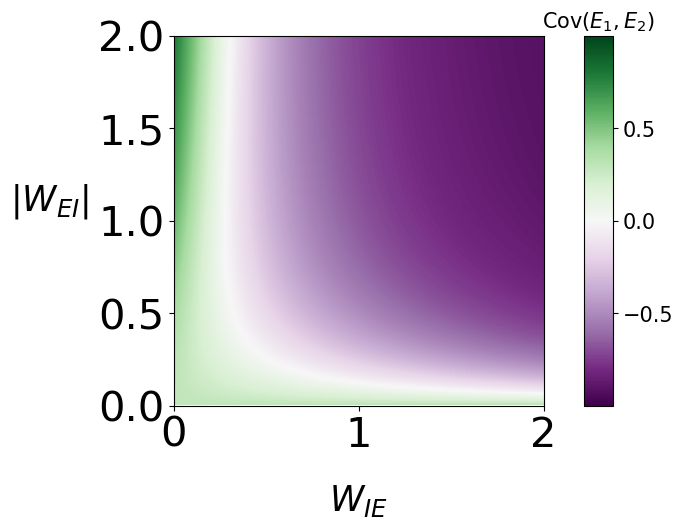

In [3]:
#range of W_EI
Wei_vec = np.linspace(0, 2, K)
Wie_vec = np.linspace(0, 2, K) 

Corrs_12 = np.zeros((K,K))
Covs_12 = np.zeros((K,K))
Max_evrp = np.zeros((K,K))

for i in range(K):
        Wei = Wei_vec[i]
        for j in range(K):
            Wie = Wie_vec[j]
            
            W[0:2,2]=-Wei  # I->E
            W[2,0:2]=Wie # E->I
            
            Cov, Corr, Max_evrp[i,j],_ = corrTheory(W, DMatrix)
            Covs_12[i,j] = Cov[0,1]
            Corrs_12[i,j] = Corr[0,1]


# plot Corr as function of Wei, Wie
fig,ax = plt.subplots()

# divnorm=colors.TwoSlopeNorm(vcenter=0)
cmap = mp.colormaps["PRGn"]

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=.4)
im = ax.imshow(np.flip(Corrs_12, axis=0), cmap=cmap, vmin=-1, vmax= 1, extent=[0, 2, 0, 2])

cbar=fig.colorbar(im, cax=cax, orientation='vertical')

ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xlabel(r'$W_{IE}$', fontsize=25, labelpad=20)
ax.set_ylabel(r'$|W_{EI}|$', rotation=0, fontsize=25, labelpad=35)
cbar.ax.yaxis.set_tick_params(labelsize=15)
cbar.ax.yaxis.set_ticks([-0.5, 0, 0.5])
plt.title(r'Cov$(E_1,E_2)$', fontsize=15)

plt.show()

### Fig 3D and 3E
#### Now, lets pick a specific point in this 2D space, and perform the pathway expansion
Note: The method below doesn't work in the ISN regime, since W_Exc sub-matrix has eigenvalues > 1 and the series doesn't converge. Though, the series expansion for the full matrix W does...it just requires a lot of terms 

In [4]:
# Full matrix: Example 1 (W_ie = 0.07, W_ei = -1; red asterisk)
W1 = np.block([[Wee, alpha*Wee, -1],
     [alpha*Wee, Wee, -1],
     [0.07, 0.07, -Wii]])

# Full matrix: Example 2 (W_ie = 2, W_ei = -0.05; blue asterisk)
W2 = np.block([[Wee, alpha*Wee, -0.05],
     [alpha*Wee, Wee, -0.05],
     [2, 2, -Wii]])

# Excitatory sub-matrix (same in both cases above
WExc = np.block([[Wee, alpha*Wee],
     [alpha*Wee, Wee]])

# Total number of orders to include in pathway expansion
# 0th, 1st, ..., totalOrders
totalOrders = 3

# Do the expansion for each of the matrices above
covData1, fullCov1 = covExpansion(W1, DMatrix, totalOrders)
covData2, fullCov2 = covExpansion(W2, DMatrix, totalOrders)
covDataExc, fullCovExc = covExpansion(WExc, DMatrixExc, totalOrders)

# Break apart the excitatory and inhibitory subpaths
covDataAll = np.zeros((totalOrders+1)*3)
covDataAll[::3] = covDataExc
covDataAll[1::3] = covData1-covDataExc # Inhibitory paths
covDataAll[2::3] = covData2-covDataExc # Inhibitory paths

# Calculate the total correlation
rho12_ex1 = np.sqrt(fullCov1[0,0]*fullCov1[1,1])
rho12_ex2 = np.sqrt(fullCov2[0,0]*fullCov2[1,1])
labels = ['Exc','Inh 1','Inh 2']

#### Plot Fig 3D

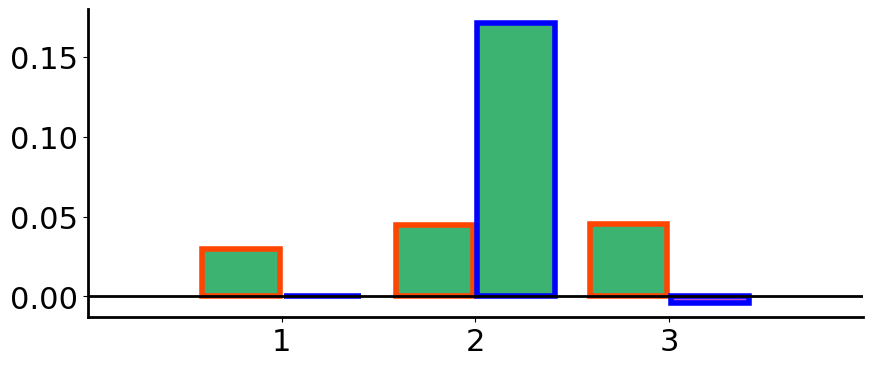

In [5]:
indicesInclude =[False, False, False, True, True, False, True, True, False, True, True, False]
covDataAllAdj = covDataAll[indicesInclude]/rho12_ex1
labels=[]

width = 0.4

for i in range(totalOrders):
    labels = labels+[str(i+1)+' (Exc)', str(i+1)+' (Inh)']

fig, ax = plt.subplots(figsize=(10,4))
j = [1, 1, 2, 2, 3, 3]
for i in range(len(np.nonzero(indicesInclude)[0])):
    x = j[i] + (width+.02)/2
    if covDataAllAdj[i] > 0:
        setColor = 'mediumseagreen'
    else:
        setColor = 'mediumorchid'       
    if (i%2) == 0:
        setHatch = 'x'
        setEdgecolor = 'orangered'
        x = j[i] - (width+.02)/2
    else:
        setHatch = '/'
        setEdgecolor = 'blue'
    ax.bar(x, covDataAllAdj[i], edgecolor=setEdgecolor, color=setColor, width=width, linewidth=4)
    
plt.plot([-0.5, 5.5],[0, 0],color='black',linewidth=2)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(0,4)
ax.set_xticks([1, 2, 3])#, ['1', '2', '3'])
ax.tick_params(labelsize=22)

plt.show()

#### Plot Fig 3E

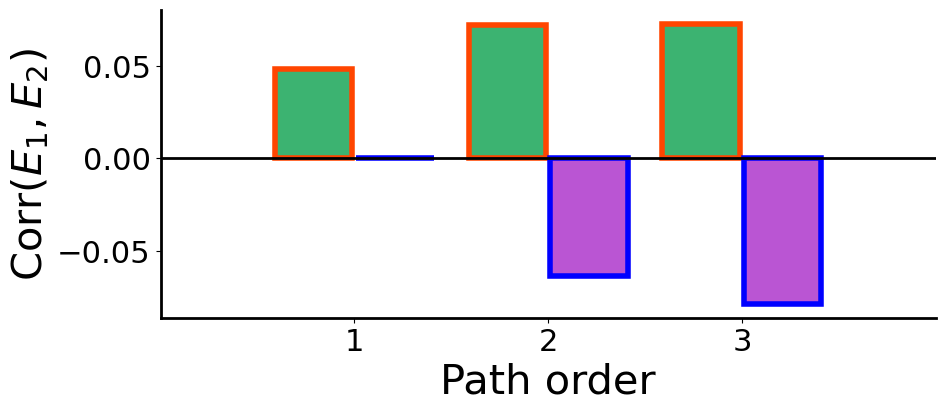

In [6]:
indicesInclude =[False, False, False, True, False, True, True, False, True, True, False, True]
covDataAllAdj = covDataAll[indicesInclude]/rho12_ex2
labels=[]
for i in range(totalOrders):
    labels = labels+[str(i+1)+' (Exc)', str(i+1)+' (Inh)']

fig, ax = plt.subplots(figsize=(10,4))
j = [1, 1, 2, 2, 3, 3]
for i in range(totalOrders*2):
    x = j[i] + (width+.02)/2
    if covDataAllAdj[i] > 0:
        setColor = 'mediumseagreen'
    else:
        setColor = 'mediumorchid'       
    if (i%2) == 0:
        setHatch = 'x'
        setEdgecolor = 'orangered'
        x = j[i] - (width+.02)/2
    else:
        setHatch = '/'
        setEdgecolor = 'blue'
    ax.bar(x, covDataAllAdj[i], edgecolor=setEdgecolor, color=setColor, width=width, linewidth=4)
    
plt.plot([-0.5, 5.5],[0, 0],color='black',linewidth=2)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(0,4)
ax.set_xticks([1, 2, 3])#, ['1', '2', '3'])
ax.tick_params(labelsize=22)
ax.set_xlabel('Path order', fontsize=30)
ax.set_ylabel('Corr$(E_1,E_2)$', fontsize=30)
plt.show()